# Interação e Concorrência
## Trabalho Prático - Grupo 13


Grupo:
- André Morandi A86912
- Ivo Lima A90214


In [74]:
# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, transpile

from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_state_hinton

import matplotlib.pyplot as plt
%matplotlib inline

# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

Nosso número $N$ = $13$

Temos de de usar um $\textit{quantum algorithm}$ para encontrar $s$ tal que

$$ s = N \space mod \space 8 $$

In [138]:
N = 13
s = N % 8
s

5

numa lista não ordenada

In [139]:
ss = bin(s)[2:]
ss

'101'

Portanto, como $5$ em binário é $101$, precisamos de 3 qubits para representar

In [140]:
x = 3
print('Number of qubits: ', x)

Number of qubits:  3


In [141]:
qr_x = QuantumRegister(x, 'x')

In [142]:
backend = Aer.get_backend("qasm_simulator")

### Implementação do Oracle

In [145]:
def phase_oracle(qc_Grover, qr_x):
    qc_Grover.x(qr_x[0])
    qc_Grover.ccx(qr_x[0], qr_x[1], qr_x[2])
    qc_Grover.x(qr_x[2])

### Diffuser

In [146]:
def diffuser(qc_Grover,qr_x):
    qc_Grover.h(qr_x[0])
    qc_Grover.x(qr_x[0])
    
    qc_Grover.h(qr_x[1])
    qc_Grover.x(qr_x[1])
    
    qc_Grover.h(qr_x[2])
    qc_Grover.x(qr_x[2])
    
    qc_Grover.h(qr_x[2])
    qc_Grover.ccx(qr_x[0],qr_x[1],qr_x[2])
    qc_Grover.h(qr_x[2])
    
    qc_Grover.h(qr_x[2])
    qc_Grover.x(qr_x[2])
    
    qc_Grover.h(qr_x[1])
    qc_Grover.x(qr_x[1])
    
    qc_Grover.h(qr_x[0])
    qc_Grover.x(qr_x[0])

O $qc\_Grover$ vai inicializer o quantum circuit

In [147]:
def init(qc_Grover):
    qc_Grover.h(0)
    qc_Grover.h(1)
    qc_Grover.h(2)

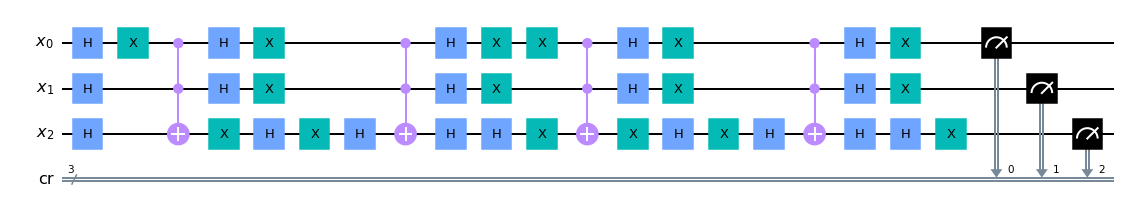

In [132]:
cr=ClassicalRegister(x,'cr')
qc_Grover= QuantumCircuit(qr_x,cr)


init(qc_Grover)


for t in range(2):
    # phase oracle
    phase_oracle(qc_Grover, qr_x)
    # diffuser
    diffuser(qc_Grover,qr_x)
qc_Grover.measure(qr_x,cr)

qc_Grover.draw(output='mpl')

Explicar resultado obtido

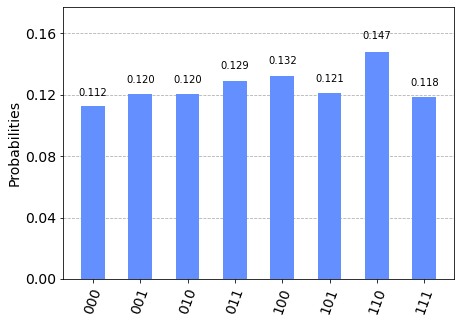

In [133]:
shots=1024
result = execute(qc_Grover, backend, shots=shots).result()
counts_sim = result.get_counts(qc_Grover)
plot_histogram(counts_sim)

In [134]:
qc_Grover.depth()

21

Run on a quantum computer

In [135]:
provider = IBMQ.load_account()
provider.backends()

ibmqfactory.load_account:WARNING:2021-05-31 20:20:01,115: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') fr

In [136]:
# Backend overview
import qiskit.tools.jupyter

%qiskit_backend_overview

In [137]:
from qiskit.tools.monitor import backend_overview, backend_monitor

backend_overview()

ibmq_manila                  ibmq_quito                   ibmq_belem
-----------                  ----------                   ----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 18             Pending Jobs: 4              Pending Jobs: 0
Least busy:   False          Least busy:   False          Least busy:   True
Operational:  True           Operational:  True           Operational:  True
Avg. T1:      156.5          Avg. T1:      82.4           Avg. T1:      82.6
Avg. T2:      69.7           Avg. T2:      76.5           Avg. T2:      82.6



ibmq_lima                    ibmq_santiago                ibmq_athens
---------                    -------------                -----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 12             Pending Jobs: 13             Pending Jobs: 6
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           Operatio

Explicar porque escolhemos a maquina

In [ ]:
# Generate the calibration circuits
qr = QuantumRegister(x)


# meas_calibs:
# list of quantum circuit objects containing the calibration circuits
# state_labels:
# calibration state labels
meas_calibs, state_labels = complete_meas_cal(qubit_list=[0,1,2,3,4], qr=qr, circlabel='mcal')


In [ ]:
state_labels